In [1]:
%load_ext lab_black
import pandas as pd
import json
import requests
import numpy as np

from config import g_key
from config import mapbox_token

import plotly.express as px

# Part II : VacationPy
----


## Loading in CSV

In [2]:
city_data_to_load = "Resources/city_result.csv"

city_data = pd.read_csv(city_data_to_load)
df = city_data
df.head(2)

,Unnamed: 0,City,Lat,Lon,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,0,Bambous Virieux,-20.34,57.76,75.2,60,40,6.93,MU,1600869990
1,1,Barrow,71.29,-156.79,30.2,68,90,6.93,US,1600869902


In [3]:
# Adding a new column to the DataFrame that will house the Lat and Lon together as a string.

df["Lat_Lon"] = df["Lat"].astype(str) + "," + df["Lon"].astype(str)
df.head(2)

,Unnamed: 0,City,Lat,Lon,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date,Lat_Lon
0,0,Bambous Virieux,-20.34,57.76,75.2,60,40,6.93,MU,1600869990,"-20.34,57.76"
1,1,Barrow,71.29,-156.79,30.2,68,90,6.93,US,1600869902,"71.29,-156.79"


In [4]:
# Dropping unnecessary columns.
df.drop(columns=["Unnamed: 0", "Date"], inplace=True)

In [22]:
# Filtering DataFrame to display only those cities with ideal weather conditions.
perfect_weather_df = df[
    (df["Max Temp"] <= 80)
    & (df["Max Temp"] >= 60)
    & (df["Wind Speed"] <= 20)
    & (df["Cloudiness"] <= 30)
    # I am adding this variable which is not part of the HW assignment. I do not like long flights, so I am keeping my flights all in the Western Hemisphere.
    & ((df["Lon"] <= -25) & (df["Lon"] >= -160))
]
perfect_weather_df

,City,Lat,Lon,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Lat_Lon
7,Rikitea,-23.12,-134.97,71.92,73,1,13.85,PF,"-23.12,-134.97"
26,Jamestown,42.10,-79.24,60.01,81,1,8.14,US,"42.1,-79.24"
29,Faanui,-16.48,-151.75,78.75,79,4,16.26,PF,"-16.48,-151.75"
60,Bethel,41.37,-73.41,60.01,67,1,4.70,US,"41.37,-73.41"
77,Taltal,-25.40,-70.48,62.15,61,26,4.94,CL,"-25.4,-70.48"
100,São Pedro do Sul,-29.62,-54.18,62.60,72,0,5.82,BR,"-29.62,-54.18"
133,Constitución,-35.33,-72.42,60.67,55,0,3.78,CL,"-35.33,-72.42"
178,Cidreira,-30.18,-50.21,65.46,64,0,11.90,BR,"-30.18,-50.21"
184,Pacifica,37.61,-122.49,60.80,72,1,9.17,US,"37.61,-122.49"
193,Jataizinho,-23.25,-50.98,73.40,56,1,10.29,BR,"-23.25,-50.98"


In [6]:
perfect_weather_df["Lat_Lon"].value_counts().sum()

29

In [7]:
lat_lon_list = perfect_weather_df["Lat_Lon"].tolist()

In [8]:
# Creating the API request and testing it by creating a Json for a single city from the list I created above.
hotels = requests.get(
    "https://maps.googleapis.com/maps/api/place/nearbysearch/json",
    params={
        "key": g_key,
        "location": lat_lon_list[17],
        "radius": "5000",
        "type": "lodging",
    },
).json()

In [9]:
hotels

{'html_attributions': [],
 'results': [{'business_status': 'OPERATIONAL',
   'geometry': {'location': {'lat': -17.7446636, 'lng': -149.160492},
    'viewport': {'northeast': {'lat': -17.7434280697085,
      'lng': -149.1591888197085},
     'southwest': {'lat': -17.7461260302915, 'lng': -149.1618867802915}}},
   'icon': 'https://maps.gstatic.com/mapfiles/place_api/icons/lodging-71.png',
   'name': 'Pension Oaoa',
   'photos': [{'height': 1440,
     'html_attributions': ['<a href="https://maps.google.com/maps/contrib/100198529438043001778">rose tuaira</a>'],
     'photo_reference': 'CmRaAAAAfFipL0fQvoqijiL7uPoL3nxAUPH15D37fuD6tas1VP-rxmctEx6i3xZZY37hbAofl2c2p37oxhea0c45h8KnIjZsewhDg7ILGt0l3aKzecCSbRswiH-A7ZS6ajVmby3qEhAfNlVTwJt9GXrVcmhuwGkLGhSD0UqA5sWSV4MtgrvIQGudd_LvEw',
     'width': 2560}],
   'place_id': 'ChIJdf8QnG2pm3YRMkU5rhrhFa8',
   'plus_code': {'compound_code': '7R4Q+4R Taiarapu-Ouest, French Polynesia',
    'global_code': '53JG7R4Q+4R'},
   'rating': 4.3,
   'reference': 'ChI

In [10]:
# Function to extract data for the first hotel for each city.
def extract_data(data):
    data = data["results"][0]
    return {
        "Hotel Name": data["name"],
        "Lat": data["geometry"]["location"]["lat"],
        "Lon": data["geometry"]["location"]["lng"],
    }

In [11]:
# Creating Blank List and iterating and printing latitude and longitude values to confirm what's values are being inserted in my params.
hotel_results = []

print("Beginning Data Retrieval")
print("----------------------------------------")

for lat_lon in lat_lon_list:
    try:
        print(lat_lon)
        data = requests.get(
            "https://maps.googleapis.com/maps/api/place/nearbysearch/json",
            params={
                "key": g_key,
                "location": lat_lon,
                "radius": "5000",
                "type": "lodging",
            },
        ).json()
        hotel_result = extract_data(data)
        hotel_results.append(hotel_result)
    except Exception as e:
        print(e)
        print(f"{lat_lon} Not found. Skipping...")
        continue
print("----------------------------------------")
print("Data Retrieval Complete")
print("----------------------------------------")

Beginning Data Retrieval
----------------------------------------
-23.12,-134.97
42.1,-79.24
-16.48,-151.75
41.37,-73.41
-25.4,-70.48
-29.62,-54.18
-35.33,-72.42
-30.18,-50.21
37.61,-122.49
-23.25,-50.98
30.48,-115.95
40.66,-73.58
17.96,-102.2
20.89,-156.47
37.1,-113.58
35.15,-114.57
-14.83,-64.9
-17.73,-149.15
41.14,-73.36
43.75,-81.72
30.37,-88.56
42.56,-114.46
31.55,-110.3
41.71,-70.23
8.27,-80.55
-17.53,-149.33
-28.97,-51.07
42.16,-72.33
45.02,-93.22
----------------------------------------
Data Retrieval Complete
----------------------------------------


In [12]:
# Converting returned dictionaries to a DataFrame
hotel_results_df = pd.DataFrame.from_dict(hotel_results)
hotel_results_df

,Hotel Name,Lat,Lon
0,Pension Maro'i,-23.120620,-134.968753
1,Hampton Inn & Suites Jamestown,42.118457,-79.242773
2,Bora-Bora Pearl Beach Resort & Spa,-16.475941,-151.772479
3,Courtyard by Marriott Danbury,41.411371,-73.415265
4,Residencial Karime,-25.408999,-70.484308
5,Sítio Hotel e Eventos,-29.637853,-54.185756
6,Hotel Boutique Las Azucenas,-35.333263,-72.418461
7,Hotel Castelo,-30.177881,-50.203501
8,"Pacifica Lighthouse, Trademark Collection by W...",37.609665,-122.496375
9,Chácara Cris e Dui,-23.246971,-50.983784


In [50]:
# Rounding decimals for latitude and longitude so I can use them to merge the hotel DataFrame with the perfect weather DataFrame.
hotel_results_round_df = hotel_results_df.round(decimals=1)
hotel_results_round_df.head(2)

,Hotel Name,Lat,Lon
0,Pension Maro'i,-23.1,-135.0
1,Hampton Inn & Suites Jamestown,42.1,-79.2


In [67]:
perfect_weather_round_df = perfect_weather_df.round(decimals=1)
perfect_weather_round_df.drop(columns=["Lat_Lon"], inplace=True)

In [68]:
map_df = pd.merge(
    hotel_results_round_df, perfect_weather_round_df, how="left", on="Lat"
)
map_df

,Hotel Name,Lat,Lon_x,Lat_Lon,City,Lon_y,Max Temp,Humidity,Cloudiness,Wind Speed,Country
0,Pension Maro'i,-23.1,-135.0,"-23.1, -135.0",Rikitea,-135.0,71.9,73.0,1.0,13.8,PF
1,Hampton Inn & Suites Jamestown,42.1,-79.2,"42.1, -79.2",Jamestown,-79.2,60.0,81.0,1.0,8.1,US
2,Bora-Bora Pearl Beach Resort & Spa,-16.5,-151.8,"-16.5, -151.8",Faanui,-151.8,78.8,79.0,4.0,16.3,PF
3,Courtyard by Marriott Danbury,41.4,-73.4,"41.4, -73.4",Bethel,-73.4,60.0,67.0,1.0,4.7,US
4,Residencial Karime,-25.4,-70.5,"-25.4, -70.5",Taltal,-70.5,62.2,61.0,26.0,4.9,CL
5,Sítio Hotel e Eventos,-29.6,-54.2,"-29.6, -54.2",São Pedro do Sul,-54.2,62.6,72.0,0.0,5.8,BR
6,Hotel Boutique Las Azucenas,-35.3,-72.4,"-35.3, -72.4",Constitución,-72.4,60.7,55.0,0.0,3.8,CL
7,Hotel Castelo,-30.2,-50.2,"-30.2, -50.2",Cidreira,-50.2,65.5,64.0,0.0,11.9,BR
8,"Pacifica Lighthouse, Trademark Collection by W...",37.6,-122.5,"37.6, -122.5",Pacifica,-122.5,60.8,72.0,1.0,9.2,US
9,Chácara Cris e Dui,-23.2,-51.0,"-23.2, -51.0",Jataizinho,-51.0,73.4,56.0,1.0,10.3,BR


In [19]:
# Setting MapBox token.
px.set_mapbox_access_token(mapbox_token)

In [69]:
# Generating scatter map.
fig = px.scatter_mapbox(
    map_df,
    lat="Lat",
    lon="Lon_x",
    color="Humidity",
    title="Perfect Weather Vaction Spots w/ Hotels as of 9/25/2020",
    hover_data=["Hotel Name", "City", "Country"],
    height=850,
    width=1000,
)

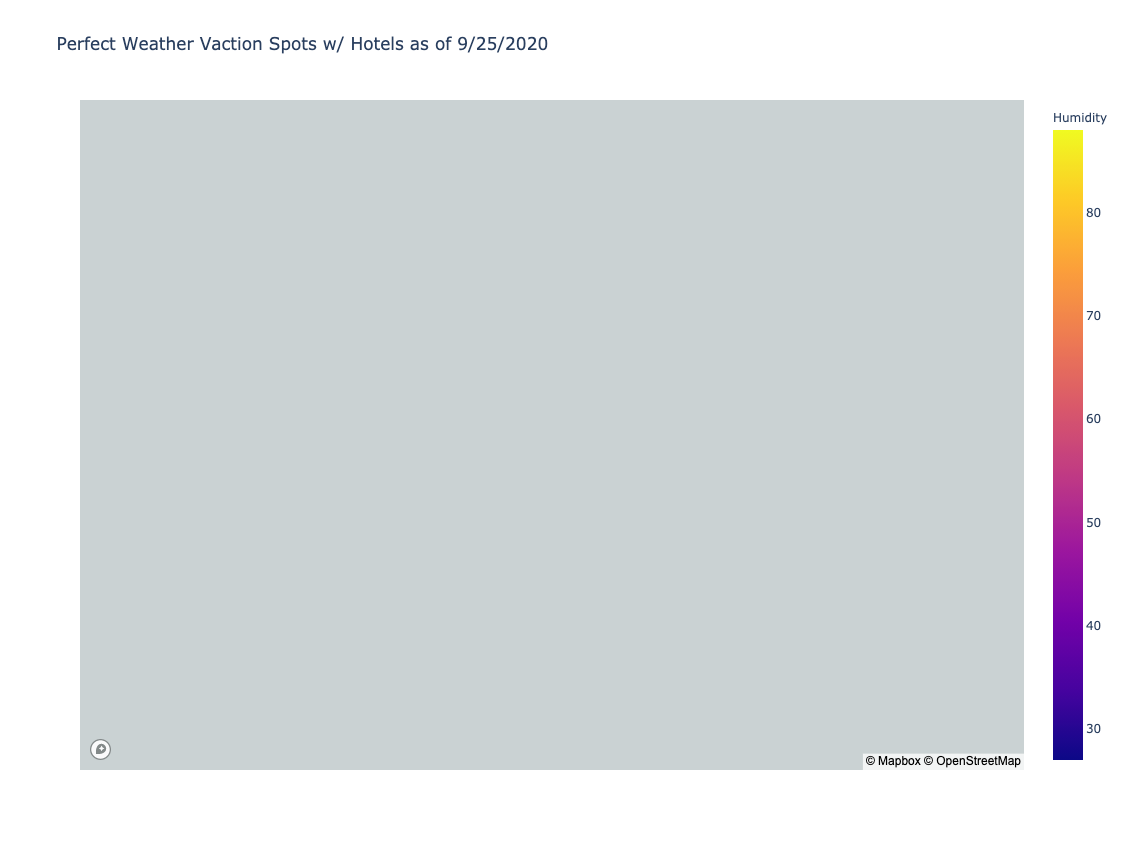

In [70]:
fig.show()